# Attempt: ABC SMC applied on Lotka Volterra
**Note:**  
This is a purely ABC based file, so does not need the JAX compiled version of PINTS.

## The Lotka Volterra Model

In [2]:
import pints
import pints.toy as toy
import pints.toy.stochastic
import pints.plot
import numpy as np
import matplotlib.pyplot as plt

### Example Trajectories

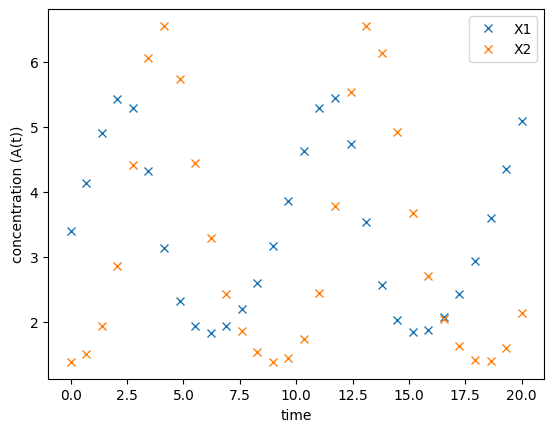

In [2]:
np.random.seed(1)

# Load the LV model
model = toy.LotkaVolterraModel()

# Example of a toy data with suggested parameter values
times = np.linspace(0, 20,30)
params = np.array([0.5,0.15,1,.3])
values = model.simulate(params, times)

plt.plot(times, values[:,0], 'x', label = 'X1')
plt.plot(times, values[:,1], 'x', label = 'X2')

plt.legend()
plt.xlabel('time')
plt.ylabel('concentration (A(t))'),
plt.show()

### Fit ABC SMC  
#### Prior: log uniform prior
Here we use the sum of squares error(SSE) for the distance function to reject/accept.  
Set the thresholds. We accept a parameter value if the $SSE<10$ for the first intermediate distribution, $SSE<7.5$ for the second one and $SSE<5$ for the last.

In [4]:
np.random.seed(8)
problem = pints.MultiOutputProblem(model, times, values)
error_measure = pints.SumOfSquaresError(problem)

log_prior = pints.UniformLogPrior([0,0.1,0,0.25], [1,0.2,2,0.35])
abc = pints.ABCController(error_measure, log_prior, method=pints.ABCSMC)

# set threshold schedule
abc.sampler().set_threshold_schedule(np.array([10,7.5,5]))

# produce intermediate distributions of size 200
abc.sampler().set_intermediate_size(200)

# set target number of samples
abc.set_n_samples(1200)

# log to screen
abc.set_log_to_screen(True)

print('Running...')
samples  = abc.run()
print('Done')

/var/folders/3z/d020c1ln2rbdn3rrr_x9nwxh0000gn/T/ipykernel_25625/875981682.py:5: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  log_prior = pints.UniformLogPrior([0,.1,0,.25], [1,.2,2,.35])


Running...
Using ABC-SMC
Running in sequential mode.
Starting t=0, with threshold=10.0
Iter. Eval. Acceptance rate Time m:s
1     153    0.00653594771    0:00.3
2     614    0.00325732899    0:01.1
3     1211   0.00247729149    0:01.9
20    12191  0.00164055451    0:16.6
40    20454  0.00195560771    0:27.7
60    31392  0.00191131498    0:42.3
80    44773  0.00178679115    1:00.2
100   56996  0.00175450909    1:17.6
120   71107  0.00168759756    1:35.5
140   82934  0.00168808932    1:50.2
160   94082  0.00170064412    2:04.3
180   105995  0.00169819331    2:19.5
Starting t=1, with threshold=7.5
200   114424  0.00174788506    2:30.3
220   114698  0.00191808052    2:30.7
240   114978  0.00208735584    2:31.1
260   115220  0.00225655268    2:31.4
280   115428  0.00242575458    2:31.7
300   115572  0.00259578445    2:31.9
320   115791  0.00276359993    2:32.2
340   116018  0.00293057974    2:32.6
360   116277  0.00309605511    2:32.9
380   116541  0.00326065505    2:33.3
Starting t=2, with

Can run following code to show first generation examples.
```
plt.hist([x[0] for x in samples[0:150]], label='First generation samples')
plt.xlim(0, 1)
plt.vlines(x=model.suggested_parameters()[0], linestyles='dashed', ymin=0, ymax=30, label='Actual value', color='red')
plt.legend()
plt.show()
```
Similar idea, second generation examples.
```
plt.hist([x[0] for x in samples[150:300]], label='Second generation samples')
plt.xlim(0, 1)
plt.vlines(x=model.suggested_parameters()[0], linestyles='dashed', ymin=0, ymax=30, label='Actual value', color='red')
plt.legend()
plt.show()
```
#### Demonstration

Used first 300 iterations as burn-in period.

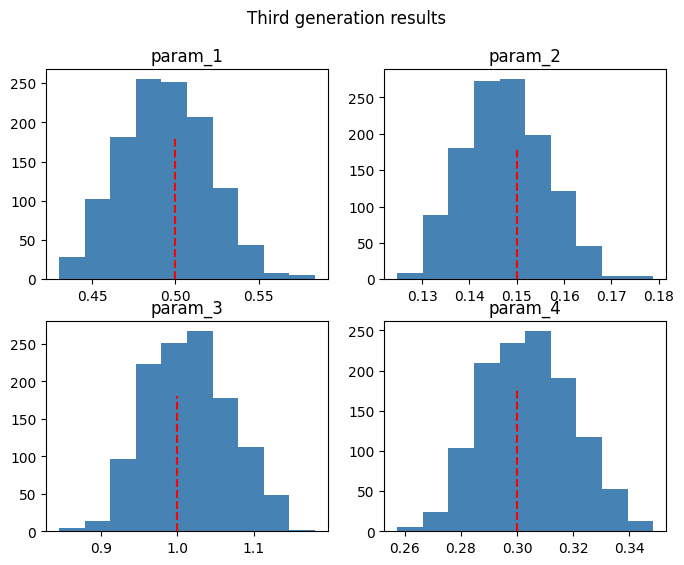

In [48]:
fig, axs = plt.subplots(2, 2, figsize=(8, 6))

axs[0,0].hist([x[0] for x in samples[300:]], color='steelblue')
axs[0,0].set_title('param_1')
axs[0,0].vlines(x=model.suggested_parameters()[0], linestyles='dashed', ymin=0, ymax=180, label='Actual value', color='red')

axs[0,1].hist([x[1] for x in samples[300:]], color='steelblue')
axs[0,1].set_title('param_2')
axs[0,1].vlines(x=model.suggested_parameters()[1], linestyles='dashed', ymin=0, ymax=180, label='Actual value', color='red')

axs[1,0].hist([x[2] for x in samples[300:]], color='steelblue')
axs[1,0].set_title('param_3')
axs[1,0].vlines(x=model.suggested_parameters()[2], linestyles='dashed', ymin=0, ymax=180, label='Actual value', color='red')

axs[1,1].hist([x[3] for x in samples[300:]], color='steelblue')
axs[1,1].set_title('param_4')
axs[1,1].vlines(x=model.suggested_parameters()[3], linestyles='dashed', ymin=0, ymax=180, label='Actual value', color='red')

plt.suptitle('Third generation results')
plt.show()

#### Prior: MVN prior  
Use another prior here to study the performance of ABC-SMC.  
**Note**: fixed numpy seed = 8

In [51]:
np.random.seed(8)
problem = pints.MultiOutputProblem(model, times, values)
error_measure = pints.SumOfSquaresError(problem)

mean = np.array([0.5,0.15,1,0.3])
var = np.diag([0.05,0.01,0.05,0.01])
log_prior = pints.MultivariateGaussianLogPrior(mean,var)
abc = pints.ABCController(error_measure, log_prior, method=pints.ABCSMC)

# set threshold schedule
abc.sampler().set_threshold_schedule(np.array([10,7.5,5]))

# produce intermediate distributions of size 200
abc.sampler().set_intermediate_size(200)

# set target number of samples
abc.set_n_samples(1200)

# log to screen
abc.set_log_to_screen(True)

print('Running...')
samples_mvn  = abc.run()
print('Done')

Running...
Using ABC-SMC
Running in sequential mode.
Starting t=0, with threshold=20
Iter. Eval. Acceptance rate Time m:s
1     254    0.00393700787    0:00.7
2     1456   0.00137362637    0:04.1
3     1668   0.00179856115    0:04.6


KeyboardInterrupt: 

## Lotka Volterra with Noise

### Generate Data with Noise

In [3]:
def add_noise(values,dim,var = 0.1):
    noise = np.random.normal(loc=0,scale=var,size=(dim,2))
    return values + noise

In [9]:
np.random.seed(7)

# Load the LV model
model = toy.LotkaVolterraModel()

# Example of a toy data with suggested parameter values
times = np.linspace(0, 30, 50)
params = np.array([0.5,0.15,1,0.3])
values = model.simulate(params, times)


In [16]:
noisy_values = add_noise(values, dim=50,var=0.2)

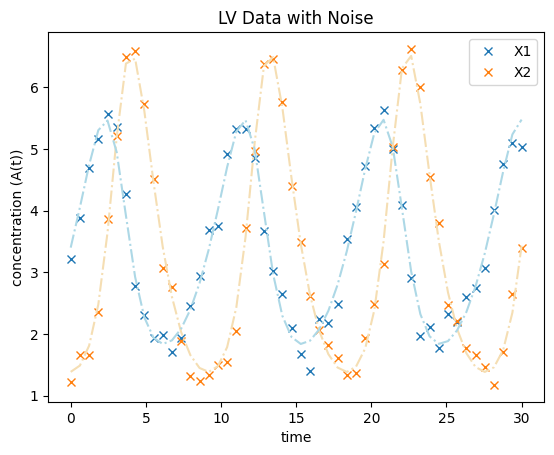

In [44]:
# fig, axs = plt.subplots(1, 2, figsize=(18, 6))

# axs[0].plot(times, values[:,0], 'x', label = 'X1',color='blue')
# axs[0].plot(times, values[:,0], '-.', label = 'X1',color='blue')
# axs[0].plot(times, values[:,1], 'x', label = 'X2',color='g')
# axs[0].plot(times, values[:,1], '-.', label = 'X2',color='g')

# axs[0].set_title('Original Data')
# axs[0].set_xlabel('time')
# axs[0].set_ylabel('concentration (A(t))')

plt.plot(times, noisy_values[:,0], 'x', label = 'X1')
plt.plot(times, noisy_values[:,1], 'x', label = 'X2')
plt.plot(times, values[:,1], '-.', color = 'wheat')
plt.plot(times, values[:,0], '-.',color='lightblue')
plt.title('LV Data with Noise')

plt.legend()
plt.xlabel('time')
plt.ylabel('concentration (A(t))'),
plt.show()

### Fit Using ABC SMC

In [23]:
np.random.seed(8)
problem = pints.MultiOutputProblem(model, times, noisy_values)
error_measure = pints.SumOfSquaresError(problem)

log_prior = pints.UniformLogPrior([0,0.1,0,0.25], [1,0.2,2,0.35])
abc = pints.ABCController(error_measure, log_prior, method=pints.ABCSMC)

# set threshold schedule
abc.sampler().set_threshold_schedule(np.array([10,7.5,5]))

# produce intermediate distributions of size 200
abc.sampler().set_intermediate_size(200)

# set target number of samples
abc.set_n_samples(1500)

# log to screen
abc.set_log_to_screen(True)

print('Running...')
samples_noise  = abc.run()
print('Done')

/var/folders/3z/d020c1ln2rbdn3rrr_x9nwxh0000gn/T/ipykernel_60914/711879037.py:5: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  log_prior = pints.UniformLogPrior([0,0.1,0,0.25], [1,0.2,2,0.35])


Running...
Using ABC-SMC
Running in sequential mode.
Starting t=0, with threshold=10.0
Iter. Eval. Acceptance rate Time m:s
1     614    0.0016286645     0:01.5
2     12273  0.000162959342   0:27.8
3     16623  0.000180472839   0:37.5
20    110502  0.000180992199   4:10.9
40    204896  0.00019522099    7:21.8
60    271487  0.000221005057   9:33.9
80    367076  0.00021793852   12:48.7
100   453763  0.000220379361  15:48.2
120   559223  0.000214583449  19:25.8
140   682394  0.000205160069  23:41.7
160   780332  0.000205040931  27:09.3
180   885926  0.000203177241  30:53.6
Starting t=1, with threshold=7.5
200   999680  0.00020006402   34:59.1
220   1002100  0.000219538968  35:05.1
240   1004396  0.000238949578  35:10.8
260   1006322  0.000258366606  35:15.5
280   1007859  0.000277816639  35:19.5
300   1009543  0.000297164162  35:24.1
320   1012037  0.000316193973  35:29.8
340   1014846  0.000335026201  35:36.1
360   1017884  0.000353674878  35:42.9
380   1019838  0.000372608199  35:48.0
S

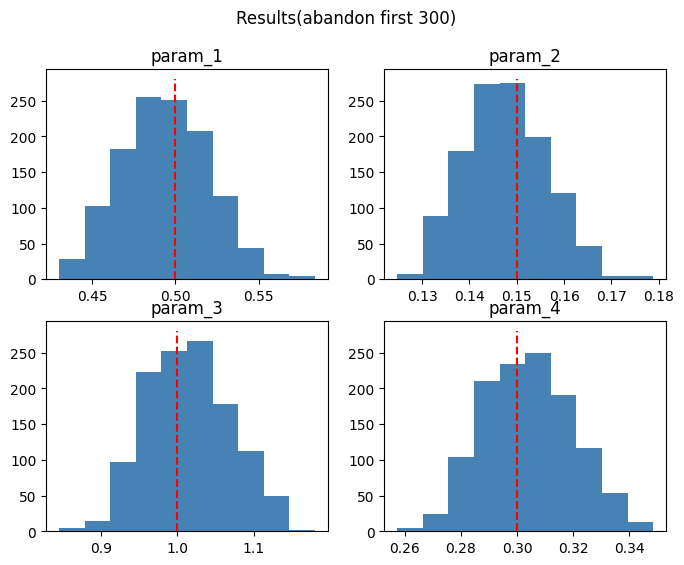

In [47]:
fig, axs = plt.subplots(2, 2, figsize=(8, 6))

axs[0,0].hist([x[0] for x in samples_noise[300:]], color='steelblue')
axs[0,0].set_title('param_1')
axs[0,0].vlines(x=model.suggested_parameters()[0], linestyles='dashed', ymin=0, ymax=280, label='Actual value', color='red')

axs[0,1].hist([x[1] for x in samples_noise[300:]], color='steelblue')
axs[0,1].set_title('param_2')
axs[0,1].vlines(x=model.suggested_parameters()[1], linestyles='dashed', ymin=0, ymax=280, label='Actual value', color='red')

axs[1,0].hist([x[2] for x in samples_noise[300:]], color='steelblue')
axs[1,0].set_title('param_3')
axs[1,0].vlines(x=model.suggested_parameters()[2], linestyles='dashed', ymin=0, ymax=280, label='Actual value', color='red')

axs[1,1].hist([x[3] for x in samples_noise[300:]], color='steelblue')
axs[1,1].set_title('param_4')
axs[1,1].vlines(x=model.suggested_parameters()[3], linestyles='dashed', ymin=0, ymax=280, label='Actual value', color='red')

plt.suptitle('Results(abandon first 300)')
plt.show()